In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


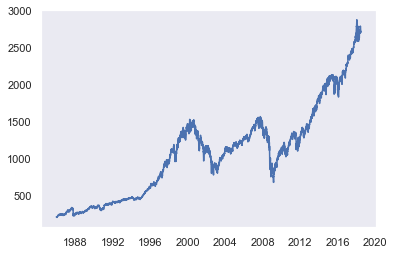

In [15]:
%matplotlib inline
plt.plot(df)
plt.grid()
plt.show()

In [16]:
### PREPROCESSING (.95,.05) ###

train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
train.shape

(7782, 1)

In [17]:
test.shape

(410, 1)

In [18]:
#rescaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaer = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])


<ipython-input-18-8a0f4ec852a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-18-8a0f4ec852a8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [19]:
#splitting data into subsequences

def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)



In [20]:
#we'll create sequences with 30 days worth of data

TIME_STEPS = 30
#reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)

X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

X_train.shape

(7752, 30, 1)

In [23]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(units = 64),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.RepeatVector(n=X_train.shape[1]),
    tf.keras.layers.LSTM(units = 64, return_sequences = True),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units = X_train.shape[2])
    )
   
])

model.compile(loss = 'mae', optimizer = 'adam')

In [24]:
num_epochs = 10
batch_size = 32
validation_split = 0.1
shuffle = False

history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_split = validation_split,
                   shuffle = shuffle)

Epoch 1/10
218/218 [==============================] - 3s 14ms/step - loss: 0.1804 - val_loss: 0.1659
Epoch 2/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1005 - val_loss: 0.1551
Epoch 3/10
218/218 [==============================] - 2s 11ms/step - loss: 0.0984 - val_loss: 0.1027
Epoch 4/10
218/218 [==============================] - 2s 11ms/step - loss: 0.0879 - val_loss: 0.1251
Epoch 5/10
218/218 [==============================] - 2s 11ms/step - loss: 0.0895 - val_loss: 0.1020
Epoch 6/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1058 - val_loss: 0.1085
Epoch 7/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1063 - val_loss: 0.1102
Epoch 8/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1105 - val_loss: 0.1058
Epoch 9/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1080 - val_loss: 0.1578
Epoch 10/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1040 - val_lo

In [25]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

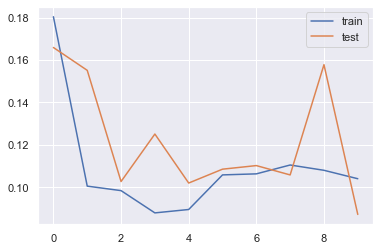

In [26]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

<AxesSubplot:>

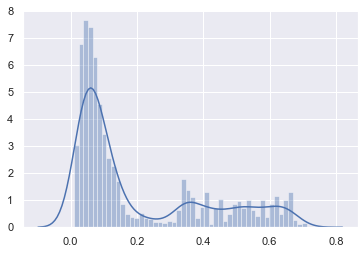

In [27]:
#calculating the mean absolute error of the training data
X_train_pred = model.predict(X_train)
train_mae_loss =  np.mean(np.abs(X_train_pred - X_train), axis = 1)
import seaborn as sns
sns.distplot(train_mae_loss, bins=50, kde=True)

In [33]:
#not much data above 0.65

THRESHOLD = 0.4
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis =1)


In [34]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

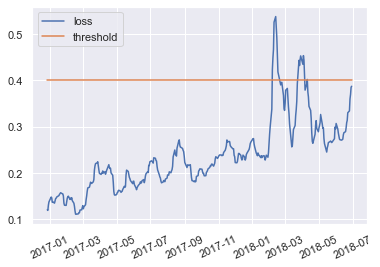

In [35]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

In [36]:
anomalies = test_score_df[test_score_df.anomaly == True]

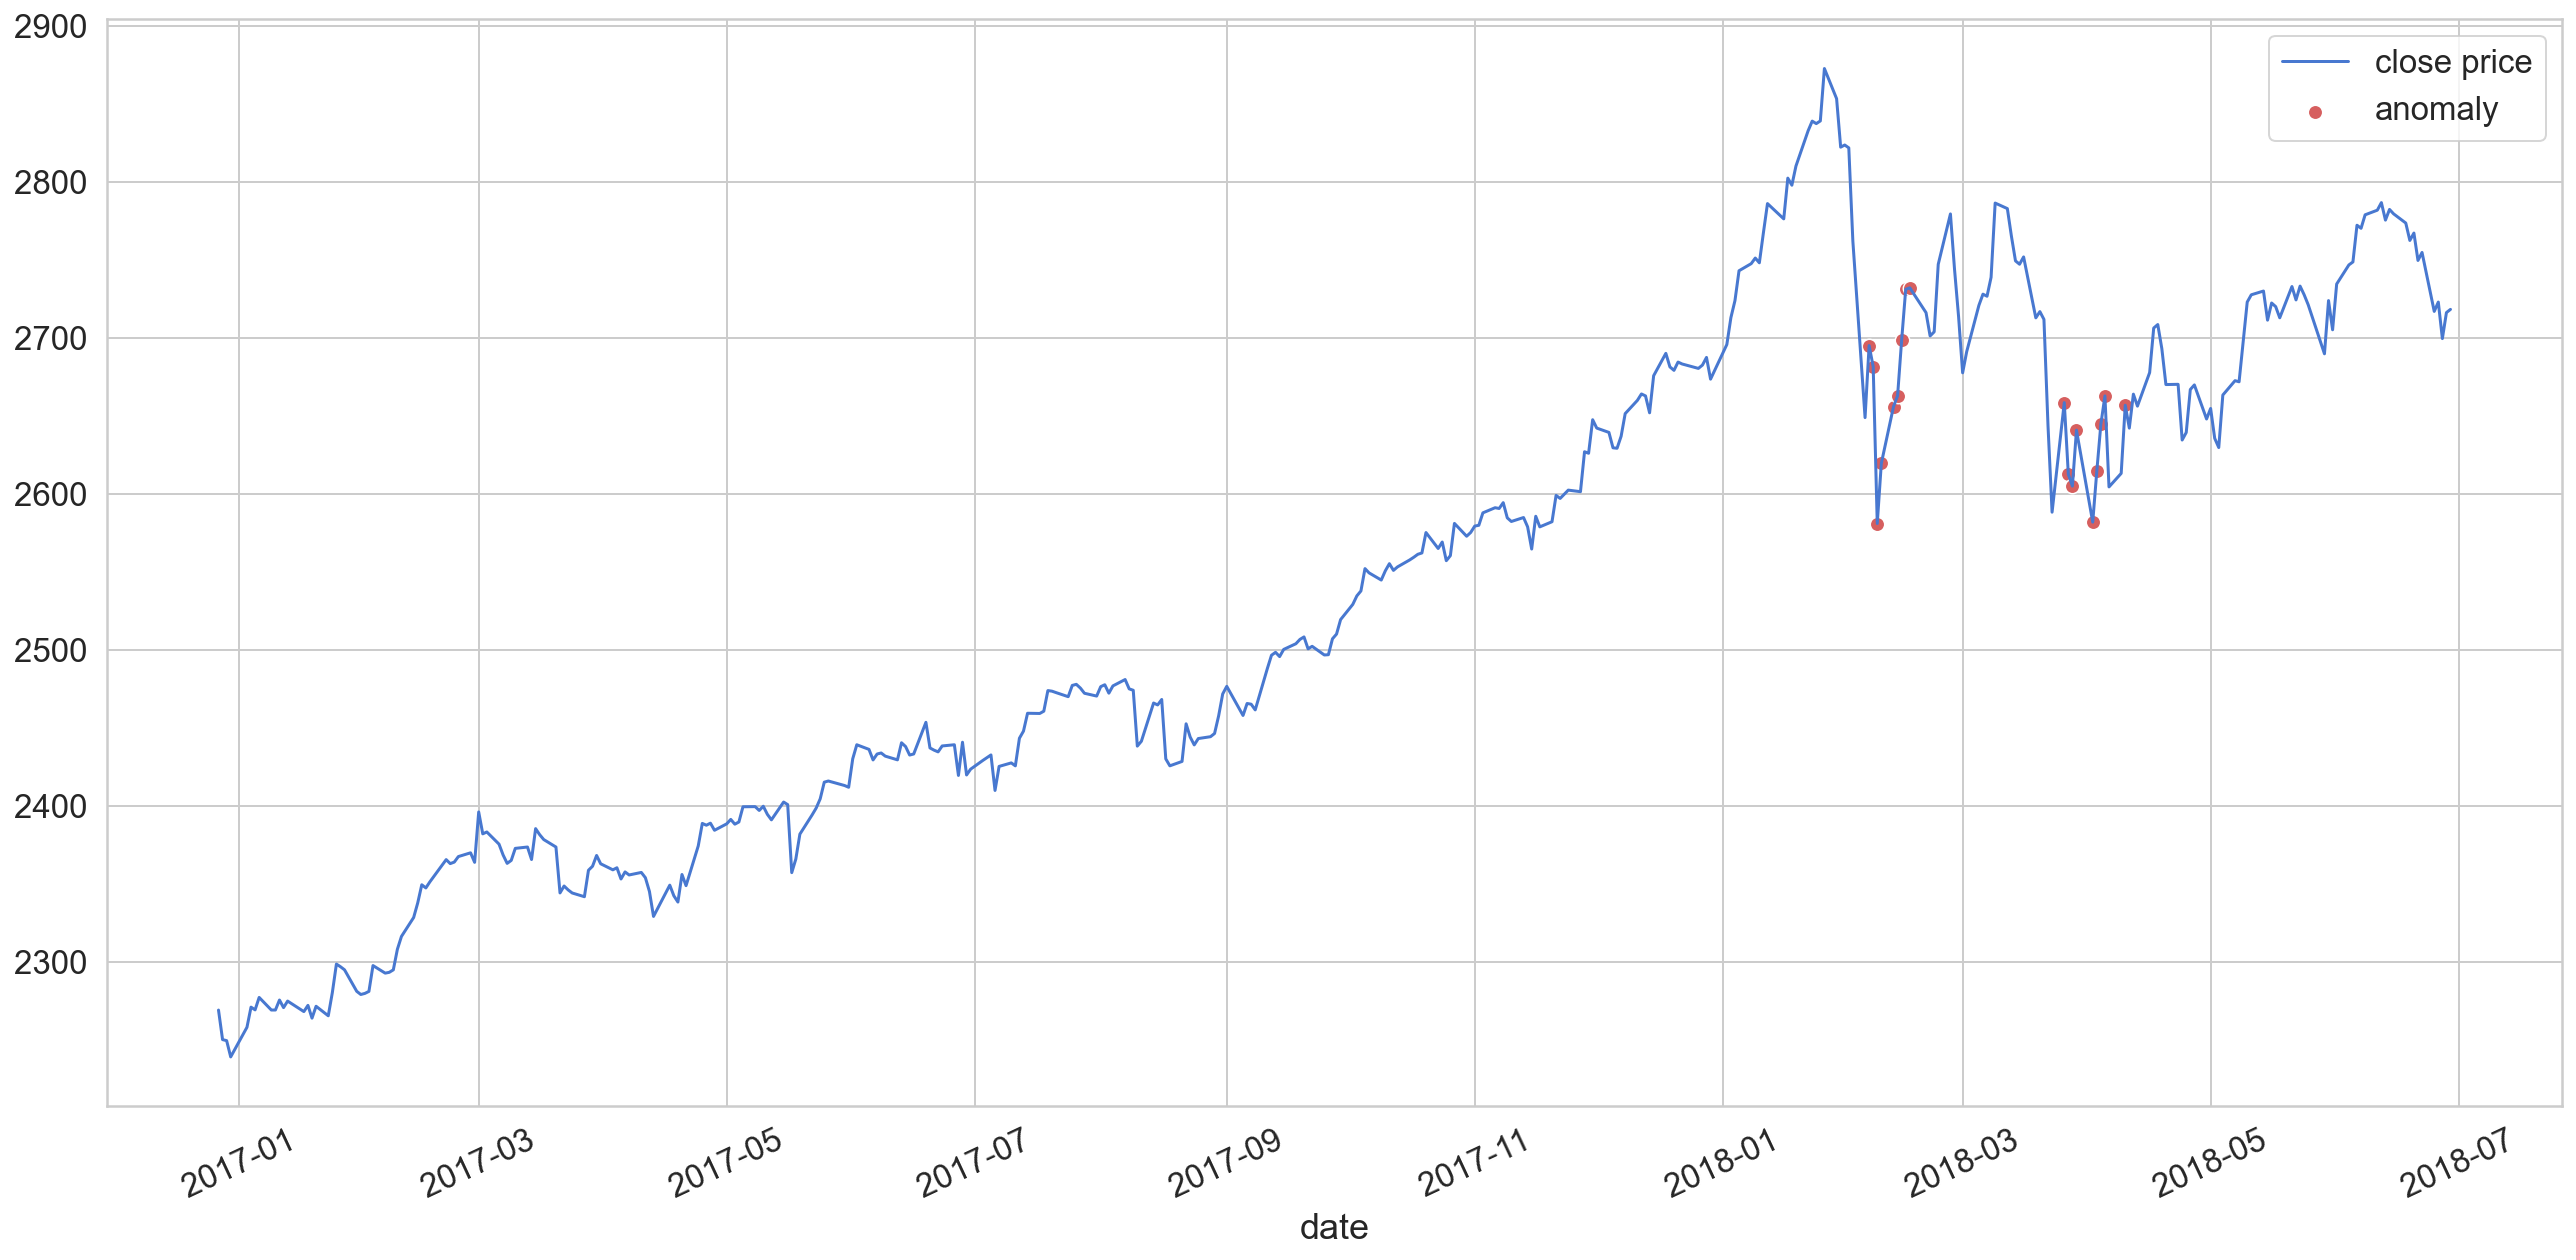

In [40]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();